In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.special import expit

## Two neuron system with synapsis



In [2]:
# Sodium activation
def gating_m(v):
    r = -40.0
    k = 9.0
    Vmax = -38.0
    std = 30.0
    Camp = 0.46
    Cbase = 0.04
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    # sigma = 1.0 / (1.0 + np.exp(-(v - r) / k))
    sigma = expit((v - r) / k)
    return tau, sigma

# Sodium inactivation
def gating_h(v):
    r = -62.0
    k = -7.0
    Vmax = -67.0
    std = 20.0
    Camp = 7.4
    Cbase = 1.2
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    sigma = expit((v - r) / k)
    return tau, sigma

# Potassium activation
def gating_n(v):
    r = -53.0
    k = 15.0
    Vmax = -79.0
    std = 50.0
    Camp = 4.7
    Cbase = 1.1
    tau = Cbase + Camp * np.exp(-((v - Vmax) ** 2) / (std ** 2))
    sigma = expit((v - r) / k)
    return tau, sigma

def sigma_syn(v):
    nu_syn = -50.0   # mV
    k = 2.0          # slope parameter (mV)
    return expit((v - nu_syn) / k)



def HH_pair_with_syn_ode(t, z, Iapp_pre_func,
                         c_pre, c_post,
                         g_tuple_pre, g_tuple_post,
                         E_tuple_pre, E_tuple_post,
                         g_syn_bar, E_syn):
    """
    ODE for a presynaptic HH neuron (pre) connected to a postsynaptic HH neuron (post)
    by a conductance-based synapse with gating variable z_syn.
    
    State vector z (length 9):
      z[0:4] = v_pre, m_pre, h_pre, n_pre
      z[4:8] = v_post, m_post, h_post, n_post
      z[8]   = z_syn   (synaptic gating for pre -> post)
    """
    # Unpack states
    v_pre, m_pre, h_pre, n_pre, v_post, m_post, h_post, n_post, z_syn = z

    # Unpack channel conductances and reversal potentials
    gNa_pre, gK_pre, gL_pre = g_tuple_pre
    gNa_post, gK_post, gL_post = g_tuple_post
    ENa_pre, EK_pre, EL_pre = E_tuple_pre
    ENa_post, EK_post, EL_post = E_tuple_post

    # HH gating (use your existing gating functions)
    tau_m_pre, sigma_m_pre = gating_m(v_pre)
    tau_h_pre, sigma_h_pre = gating_h(v_pre)
    tau_n_pre, sigma_n_pre = gating_n(v_pre)

    tau_m_post, sigma_m_post = gating_m(v_post)
    tau_h_post, sigma_h_post = gating_h(v_post)
    tau_n_post, sigma_n_post = gating_n(v_post)

    # Ionic currents (pre)
    INa_pre = gNa_pre * (m_pre ** 3) * h_pre * (v_pre - ENa_pre)
    IK_pre  = gK_pre  * (n_pre ** 4) * (v_pre - EK_pre)
    IL_pre  = gL_pre  * (v_pre - EL_pre)

    # Ionic currents (post)
    INa_post = gNa_post * (m_post ** 3) * h_post * (v_post - ENa_post)
    IK_post  = gK_post  * (n_post ** 4) * (v_post - EK_post)
    IL_post  = gL_post  * (v_post - EL_post)

    # Synaptic activation depends on presynaptic voltage (v_pre)
    sigma = sigma_syn(v_pre)

    # Synaptic gating ODE (continuous limit)
    dzdt = (sigma - z_syn) / (5.0 * (1.1 - sigma))


    # Synaptic current injected into postsynaptic neuron
    # I_syn = -gbar * z * (v_post - E_syn)
    I_syn = - g_syn_bar * z_syn * (v_post - E_syn)

    # ODEs for voltages and gates
    dvdt_pre = (Iapp_pre_func(t) - INa_pre - IK_pre - IL_pre) / c_pre
    dmdt_pre = (sigma_m_pre - m_pre) / tau_m_pre
    dhdt_pre = (sigma_h_pre - h_pre) / tau_h_pre
    dndt_pre = (sigma_n_pre - n_pre) / tau_n_pre

    # Note: I_syn is added into postsynaptic numerator (it can be inward/outward depending on E_syn)
    dvdt_post = (- INa_post - IK_post - IL_post + I_syn) / c_post
    dmdt_post = (sigma_m_post - m_post) / tau_m_post
    dhdt_post = (sigma_h_post - h_post) / tau_h_post
    dndt_post = (sigma_n_post - n_post) / tau_n_post

    return [dvdt_pre, dmdt_pre, dhdt_pre, dndt_pre,
            dvdt_post, dmdt_post, dhdt_post, dndt_post,
            dzdt]
    

# Parameters
c = 1.0

gNa = 120.0
gK = 36.0
gL = 0.3
g = (gNa, gK, gL) # gNa, gK, gL
g_syn_bar = 0.1

ENa = 55.0
EK = -77.0
EL= -54.4
E = (55.0, -77.0, -54.4) # ENa, EK, EL
E_syn = 55

dt = 0.1
Tfinal = 100.
t_span = (0.0, Tfinal)

# Define bump function for input
alpha = 2.
tau = 5.
γ = lambda t: gamma.pdf(t, a=alpha, scale=tau)

# Define input
I0 = 0.0
alpha1 = 15.; t1 = 10.;
alpha2 = 25.; t2 = t1 + 40.;
Iapp = lambda t: I0 + alpha1 * γ(t - t1) + alpha2 * γ(t - t2)


# # Initial conditions
# v0 = -64.0

# # HH gating variables at v0
# m0 = 1 / (1 + np.exp(-(v0 + 40) / 9))
# h0 = 1 / (1 + np.exp(-(v0 + 62) / -7))
# n0 = 1 / (1 + np.exp(-(v0 + 53) / 15))

# # Synaptic gating variable at steady-state
# z_syn0 = sigma_syn(v0)

# # Full initial state vector
# z0 = [v0, m0, h0, n0, z_syn0]

vpre0 = -64.0
vpost0 = -64.0

mpre0 = 1 / (1 + np.exp(-(vpre0 + 40) / 9))
hpre0 = 1 / (1 + np.exp(-(vpre0 + 62) / -7))
npre0 = 1 / (1 + np.exp(-(vpre0 + 53) / 15))

mpost0 = 1 / (1 + np.exp(-(vpost0 + 40) / 9))
hpost0 = 1 / (1 + np.exp(-(vpost0 + 62) / -7))
npost0 = 1 / (1 + np.exp(-(vpost0 + 53) / 15))

zsyn0 = sigma_syn(vpre0)

z0 = [vpre0, mpre0, hpre0, npre0, vpost0, mpost0, hpost0, npost0, zsyn0]




In [3]:
# Solve the ODE
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

#soly = solve_ivp(lambda t, z: HH_ode_syn(t, z, Iapp, c, g, E),t_span, z0, t_eval=t_eval, method='RK45',dense_output=True, max_step=dt)
soly = solve_ivp(lambda t, y: HH_pair_with_syn_ode(t, y, Iapp,
                                                  c, c,
                                                  g, g,
                                                  E, E,
                                                  g_syn_bar, E_syn),
                t_span, z0, t_eval=t_eval, method='RK45', dense_output=True,max_step=dt)



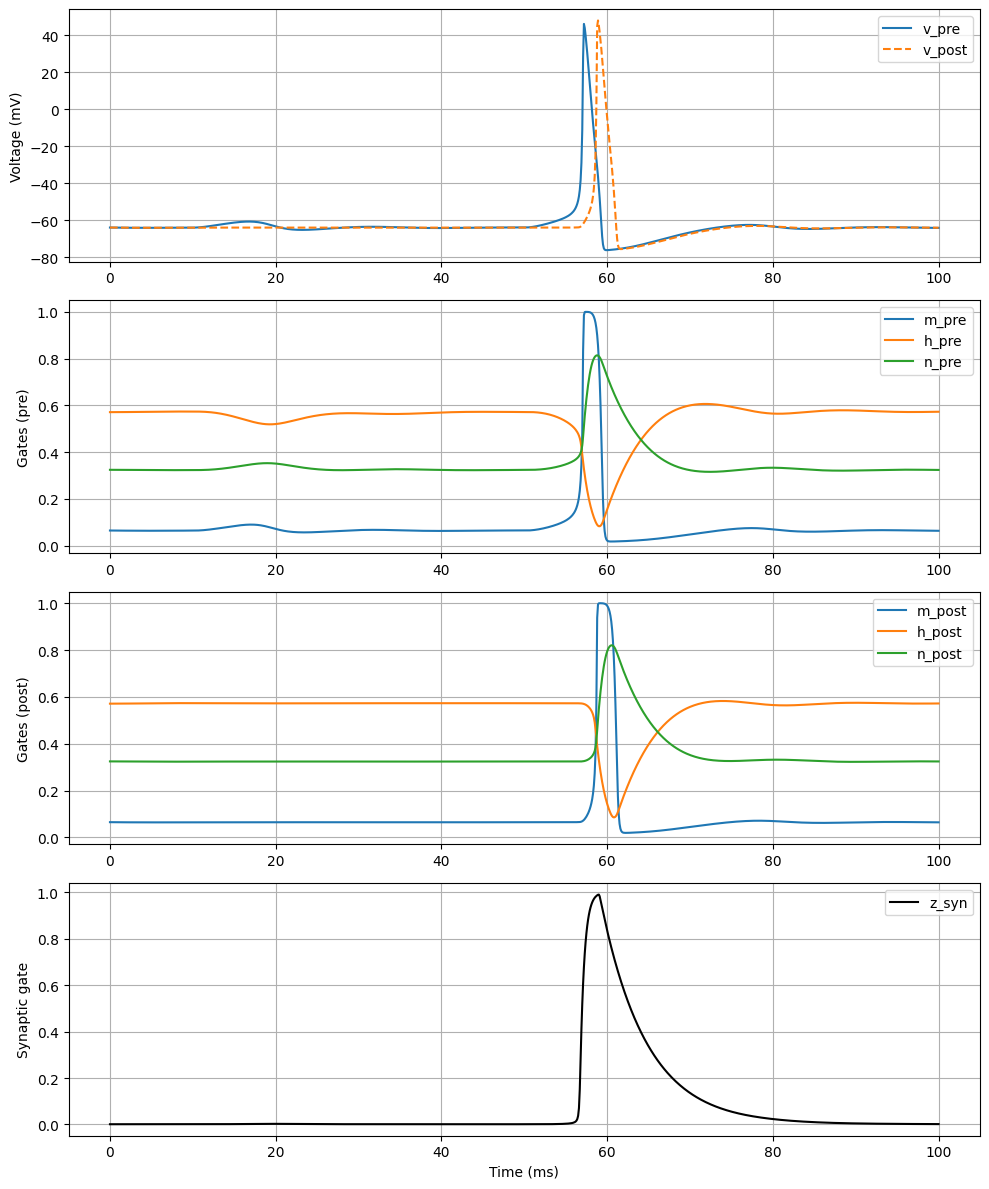

In [4]:
# Plot full state (pre + post + synapse)

t = soly.t

v_pre  = soly.y[0]
m_pre  = soly.y[1]
h_pre  = soly.y[2]
n_pre  = soly.y[3]

v_post = soly.y[4]
m_post = soly.y[5]
h_post = soly.y[6]
n_post = soly.y[7]

z_syn  = soly.y[8]


plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(t, v_pre, label='v_pre')
plt.plot(t, v_post, '--', label='v_post')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, m_pre, label='m_pre')
plt.plot(t, h_pre, label='h_pre')
plt.plot(t, n_pre, label='n_pre')
plt.ylabel('Gates (pre)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, m_post, label='m_post')
plt.plot(t, h_post, label='h_post')
plt.plot(t, n_post, label='n_post')
plt.ylabel('Gates (post)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, z_syn, color='black', label='z_syn')
plt.ylabel('Synaptic gate')
plt.xlabel('Time (ms)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
dg = 0.1
gNagrid = np.arange(106,125,dg)#[110,115,120.0,124,125]#np.linspace(100,130,20)
solx =[]
for gnaval in gNagrid:
    #solx.append(solve_ivp(lambda t, z: HH_ode(t, z, Iapp, c, (gnaval, gK, gL), E),t_span, z0, t_eval=t_eval, method='RK45',dense_output=True, max_step=dt))
    solx.append(solve_ivp(lambda t, y: HH_pair_with_syn_ode(t, y, Iapp,
                                                  c, c,
                                                  (gnaval, gK, gL), g,
                                                  E, E,
                                                  g_syn_bar, E_syn),
                t_span, z0, t_eval=t_eval, method='RK45',dense_output=True, max_step=dt))



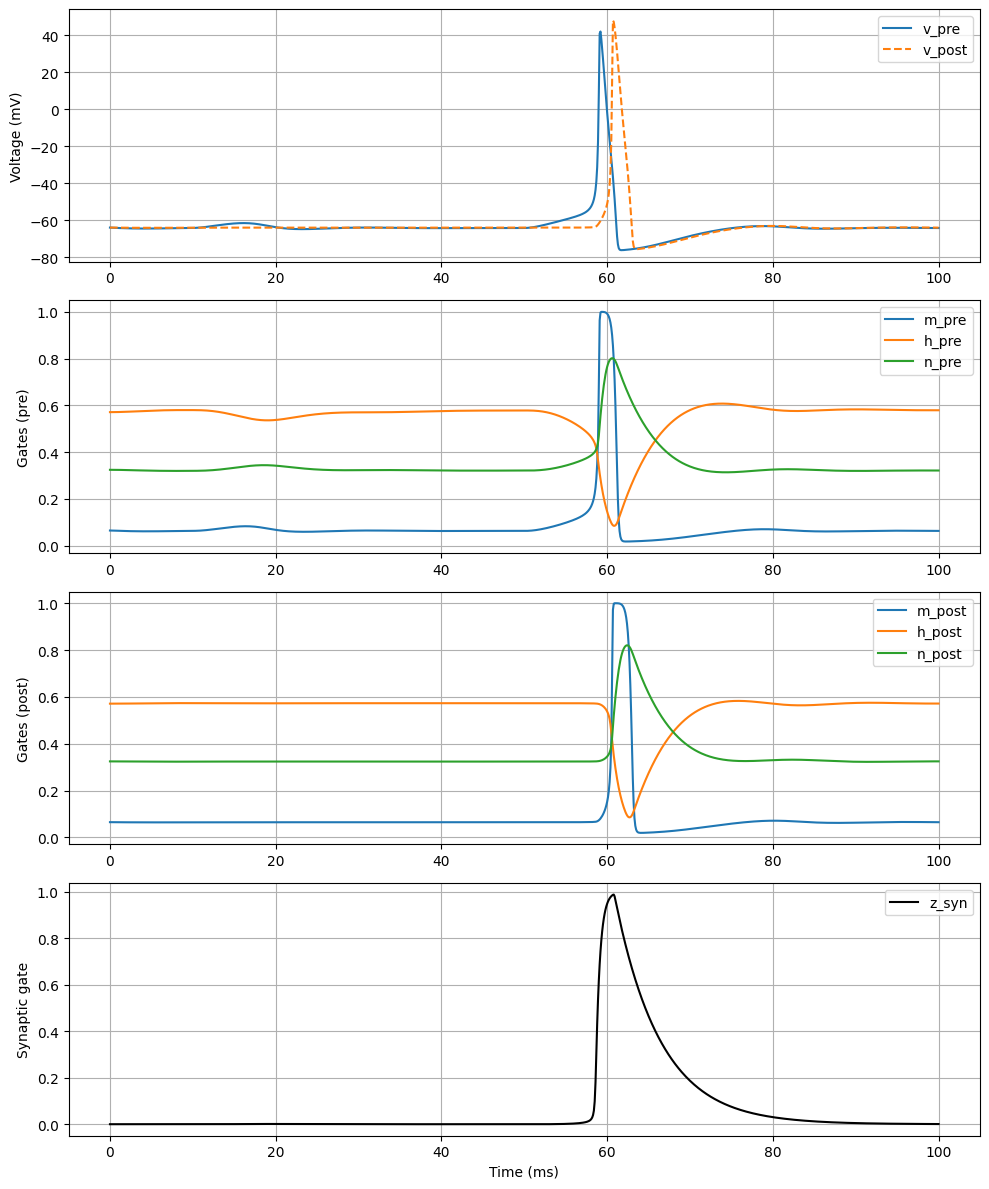

In [6]:
idx  =35
t = solx[idx].t
v_pre  = solx[idx].y[0]
m_pre  = solx[idx].y[1]
h_pre  = solx[idx].y[2]
n_pre  = solx[idx].y[3]

v_post = solx[idx].y[4]
m_post = solx[idx].y[5]
h_post = solx[idx].y[6]
n_post = solx[idx].y[7]

z_syn  = solx[idx].y[8]

# Plot full state (pre + post + synapse)

plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(t, v_pre, label='v_pre')
plt.plot(t, v_post, '--', label='v_post')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, m_pre, label='m_pre')
plt.plot(t, h_pre, label='h_pre')
plt.plot(t, n_pre, label='n_pre')
plt.ylabel('Gates (pre)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, m_post, label='m_post')
plt.plot(t, h_post, label='h_post')
plt.plot(t, n_post, label='n_post')
plt.ylabel('Gates (post)')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, z_syn, color='black', label='z_syn')
plt.ylabel('Synaptic gate')
plt.xlabel('Time (ms)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
## linearisation
def tau_prime_m(v):
    Vmax = -38.0
    std = 30.0
    Camp = 0.46
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_m(v):
    # r = -40.0
    # k = 9.0
    # return expit((v - r) / k)*(1-expit((v - r) / k))
    #return np.exp(-(v-r)/k)/(k*(1.0+np.exp(-(v-r)/k))**2)
    r = -40.0
    k = 9.0
    s = expit((v - r) / k)
    return s * (1 - s) / k

def tau_prime_h(v):
    Vmax = -67.0
    std = 20.0
    Camp = 7.4
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_h(v):
    # r = -62.0
    # k = -7.0
    # return expit((v - r) / k)*(1-expit((v - r) / k))
    # #return np.exp(-(v-r)/k)/(k*(1.0+np.exp(-(v-r)/k))**2)
    r = -62.0
    k = -7.0
    s = expit((v - r) / k)
    return s * (1 - s) / k

def tau_prime_n(v):
    Vmax = -79.0
    std = 50.0
    Camp = 4.7
    return -(2*Camp*(v-Vmax)*np.exp(-(v-Vmax)**2/std**2))/std**2

def sigma_prime_n(v):
    # r = -53.0
    # k = 15.0
    # return expit((v - r) / k)*(1-expit((v - r) / k))
    # #return np.exp(-(v-r)/k)/(k*(1.0+np.exp(-(v-r)/k))**2)
    r = -53.0
    k = 15.0
    s = expit((v - r) / k)
    return s * (1 - s) / k

def dsigma_syn_dv(v):
    """
    Derivative of sigma_syn with respect to v.
    """
    s = sigma_syn(v)
    return s * (1 - s) / 2



In [8]:
def compute_jacobian_pair(v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z, gNa_pre, gNa_post, gK_pre, gK_post):
    """
    Computes 9x9 Jacobian for HH pair with synapse.
    
    State vector:
    state = [v_pre, m_pre, h_pre, n_pre,
             v_post, m_post, h_post, n_post,
             z]
    
    Only parameters: gNa_pre, gNa_post, gK_pre, gK_post
    All other constants/functions (gL, ENa, EK, c, g_syn, E_syn,
    gating functions, synapse functions) are assumed to exist externally.
    """

    # --- Pre neuron gating ---
    tau_m_pre, sigma_m_pre = gating_m(v_pre)
    tau_h_pre, sigma_h_pre = gating_h(v_pre)
    tau_n_pre, sigma_n_pre = gating_n(v_pre)

    tau_prime_m_val_pre = tau_prime_m(v_pre)
    sigma_prime_m_val_pre = sigma_prime_m(v_pre)
    tau_prime_h_val_pre = tau_prime_h(v_pre)
    sigma_prime_h_val_pre = sigma_prime_h(v_pre)
    tau_prime_n_val_pre = tau_prime_n(v_pre)
    sigma_prime_n_val_pre = sigma_prime_n(v_pre)

    tau_m_sq_pre = tau_m_pre ** 2
    tau_h_sq_pre = tau_h_pre ** 2
    tau_n_sq_pre = tau_n_pre ** 2

    gating_m_term_pre = (sigma_prime_m_val_pre * tau_m_pre - tau_prime_m_val_pre * (sigma_m_pre - m_pre)) / tau_m_sq_pre
    gating_h_term_pre = (sigma_prime_h_val_pre * tau_h_pre - tau_prime_h_val_pre * (sigma_h_pre - h_pre)) / tau_h_sq_pre
    gating_n_term_pre = (sigma_prime_n_val_pre * tau_n_pre - tau_prime_n_val_pre * (sigma_n_pre - n_pre)) / tau_n_sq_pre

    # --- Post neuron gating ---
    tau_m_post, sigma_m_post = gating_m(v_post)
    tau_h_post, sigma_h_post = gating_h(v_post)
    tau_n_post, sigma_n_post = gating_n(v_post)

    tau_prime_m_val_post = tau_prime_m(v_post)
    sigma_prime_m_val_post = sigma_prime_m(v_post)
    tau_prime_h_val_post = tau_prime_h(v_post)
    sigma_prime_h_val_post = sigma_prime_h(v_post)
    tau_prime_n_val_post = tau_prime_n(v_post)
    sigma_prime_n_val_post = sigma_prime_n(v_post)

    tau_m_sq_post = tau_m_post ** 2
    tau_h_sq_post = tau_h_post ** 2
    tau_n_sq_post = tau_n_post ** 2

    gating_m_term_post = (sigma_prime_m_val_post * tau_m_post - tau_prime_m_val_post * (sigma_m_post - m_post)) / tau_m_sq_post
    gating_h_term_post = (sigma_prime_h_val_post * tau_h_post - tau_prime_h_val_post * (sigma_h_post - h_post)) / tau_h_sq_post
    gating_n_term_post = (sigma_prime_n_val_post * tau_n_post - tau_prime_n_val_post * (sigma_n_post - n_post)) / tau_n_sq_post

    # --- Pre voltage derivatives ---
    dvpre_dvpre = -(gNa_pre * m_pre**3 * h_pre + gK_pre * n_pre**4 + gL) / c
    dvpre_dm   = -(3 * gNa_pre * m_pre**2 * h_pre * (v_pre - ENa)) / c
    dvpre_dh   = -(gNa_pre * m_pre**3 * (v_pre - ENa)) / c
    dvpre_dn   = -(4 * gK_pre * n_pre**3 * (v_pre - EK)) / c

    # --- Post voltage derivatives ---
    dvpost_dvpost = -(gNa_post * m_post**3 * h_post + gK_post * n_post**4 + gL + g_syn_bar * z) / c
    dvpost_dm     = -(3 * gNa_post * m_post**2 * h_post * (v_post - ENa)) / c
    dvpost_dh     = -(gNa_post * m_post**3 * (v_post - ENa)) / c
    dvpost_dn     = -(4 * gK_post * n_post**3 * (v_post - EK)) / c
    dvpost_dz     = -g_syn_bar * (v_post - E_syn) / c

    # --- z derivatives ---
    s = sigma_syn(v_pre)
    s_prime = dsigma_syn_dv(v_pre)
    # dz_dz = - (1.0 / 50.0) * (1.1 - s)
    # dz_dvpre = (1.0 / 50.0) * s_prime * (1.1 - 2*s + z)

    dz_dz = -1.0 / (5.0 * (1.1 - s))
    dz_dvpre = s_prime * (1.1 - z) / (5.0 * (1.1 - s)**2)


    # --- Assemble Jacobian ---
    J = np.zeros((9, 9))

    # Pre block
    J[0, 0] = dvpre_dvpre
    J[0, 1] = dvpre_dm
    J[0, 2] = dvpre_dh
    J[0, 3] = dvpre_dn
    J[1, 0] = gating_m_term_pre
    J[1, 1] = -1.0 / tau_m_pre
    J[2, 0] = gating_h_term_pre
    J[2, 2] = -1.0 / tau_h_pre
    J[3, 0] = gating_n_term_pre
    J[3, 3] = -1.0 / tau_n_pre

    # Post block
    J[4, 4] = dvpost_dvpost
    J[4, 5] = dvpost_dm
    J[4, 6] = dvpost_dh
    J[4, 7] = dvpost_dn
    J[4, 8] = dvpost_dz
    J[5, 4] = gating_m_term_post
    J[5, 5] = -1.0 / tau_m_post
    J[6, 4] = gating_h_term_post
    J[6, 6] = -1.0 / tau_h_post
    J[7, 4] = gating_n_term_post
    J[7, 7] = -1.0 / tau_n_post

    # z row
    J[8, 0] = dz_dvpre
    J[8, 8] = dz_dz

    return J



def compute_jacobian_gNa_pre(v_pre, m_pre, h_pre, n_pre, v_post, m_post, h_post, n_post, z_syn):
    """
    Jacobian of f_mu w.r.t gNa of the pre neuron.
    Only the pre neuron voltage equation depends on gNa.
    """
    J = np.zeros(9)  # 9 states: [v_pre,m_pre,h_pre,n_pre, v_post,..., z_syn]

    # df_pre/dgNa = -d(I_Na_pre)/dgNa / c
    J[0] = - (m_pre**3) * h_pre * (v_pre - ENa) / c

    # all other derivatives w.r.t gNa_pre are zero
    # f[1:9] w.r.t gNa_pre = 0

    return J



In [9]:
id  = 10
gNaval = gNagrid[id]
Fx = []
eigenvalues = []
eigenvectors = []

# Fx100 = []
# eigenvalues100 = []
# eigenvectors100 = []

# Loop over time points
for i, t in enumerate(solx[id].t):
    x = solx[id].y[:, i]  
    v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z_syn = x
    #Jx = compute_jacobian(v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z_syn,gNaval,36)
    Jx = compute_jacobian_pair(v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z_syn, gNaval, gNaval, gK, gK)
    Fx.append(Jx)
    
    w, vvec = np.linalg.eig(Jx)
    eigenvalues.append(w)
    eigenvectors.append(vvec)

    # x100 = solx[id].y[:, i]  
    # v100, m100, h100, n100 = x100
    # Jx100 = compute_jacobian(v, m, h, n, gNaval,100) 
    # Fx100.append(Jx100)
    
    # w100, vvec100 = np.linalg.eig(Jx100)
    # eigenvalues100.append(w100)
    # eigenvectors100.append(vvec100)



<Figure size 2000x1200 with 0 Axes>

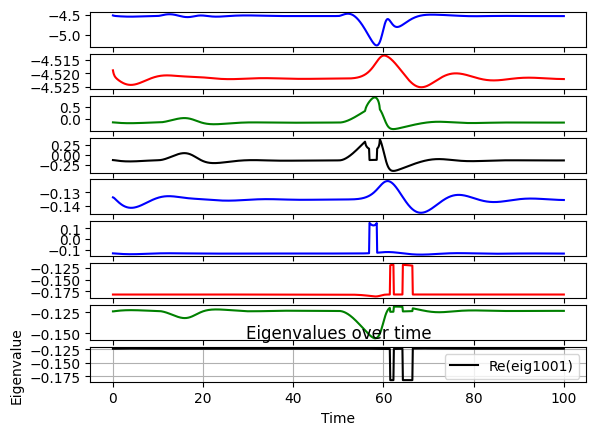

In [10]:
from itertools import cycle

colours = cycle(['red', 'green', 'blue','black'])

eigvals_array = np.array(eigenvalues)

plt.figure(figsize=(20,12))
fig, axs = plt.subplots(9)


axs[0].plot(solx[id].t, eigvals_array[:, 0].real, label=f'Re(eig{i+1})',color='b')
#
axs[1].plot(solx[id].t, eigvals_array[:, 1].real, label=f'Re(eig{i+1})',color='r')
#
axs[2].plot(solx[id].t, eigvals_array[:, 2].real, label=f'Re(eig{i+1})',color='g')
#
axs[3].plot(solx[id].t, eigvals_array[:, 3].real, label=f'Re(eig{i+1})',color='black')
#
axs[4].plot(solx[id].t, eigvals_array[:, 4].real, label=f'Re(eig{i+1})',color='b')
#
axs[5].plot(solx[id].t, eigvals_array[:, 5].real, label=f'Re(eig{i+1})',color='b')
#
axs[6].plot(solx[id].t, eigvals_array[:, 6].real, label=f'Re(eig{i+1})',color='r')
#
axs[7].plot(solx[id].t, eigvals_array[:, 7].real, label=f'Re(eig{i+1})',color='g')
#
axs[8].plot(solx[id].t, eigvals_array[:, 8].real, label=f'Re(eig{i+1})',color='black')
# plt.ylim(-3,3)
plt.xlabel('Time')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues over time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
C = np.zeros((9,9))
C[4][4]=1

def costs(x, y, T):
    e = x[4] - y
    return 0.5 * e**2 / T


def costsprime(x, y, T,C):
    grad = np.zeros_like(x)
    grad[4] = (x[4] - y) / T
    return grad



# Terminal cost gradient phi_x (here zero)
def phi_x(xT):
    return 0

In [12]:
def backpass_lambda(t, lam, sol_x, sol_y, gNaval, T, C):
    x = sol_x.sol(t)
    v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z_syn = x
    y = sol_y.sol(t)[4]

    lamx = lam[0:9]
    lammu = lam[-1]

    Fx = compute_jacobian_pair(v_pre, m_pre, h_pre, n_pre,v_post, m_post, h_post, n_post,z_syn, gNaval, gNa, gK, 100)
    Fmu = compute_jacobian_gNa_pre(v_pre, m_pre, h_pre, n_pre, v_post, m_post, h_post, n_post, z_syn)

    l_x = costsprime(x, y, T, C)
   
    dlamx_dt = - l_x - Fx.T @ lamx 
    dlamu_dt = - (Fmu.T @ lamx)

    return np.concatenate([dlamx_dt, [dlamu_dt]])


In [13]:
sol_lambda = []
lambda_traj=[]
for gnaidx, gnaval in enumerate(gNagrid):
    sol_lambda.append(solve_ivp(
        fun=lambda t, lam: backpass_lambda(t, lam, solx[gnaidx], soly, gnaval, Tfinal, C),
        t_span=(t_span[1], t_span[0]),  # Backward integration
        y0=np.zeros(10),
        t_eval=t_eval[::-1],            # Evaluate from T to 0
        method='RK45',
        max_step=dt,
        #dense_output=True
    ))
    # Reverse the solution to match forward time
    lambda_traj.append(sol_lambda[gnaidx].y[:, ::-1])  # Now shape (4, len(t_eval)), time increasing



/tmp/ipykernel_41977/867679863.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.5 * np.trapz(e**2, sol_model.t) / T


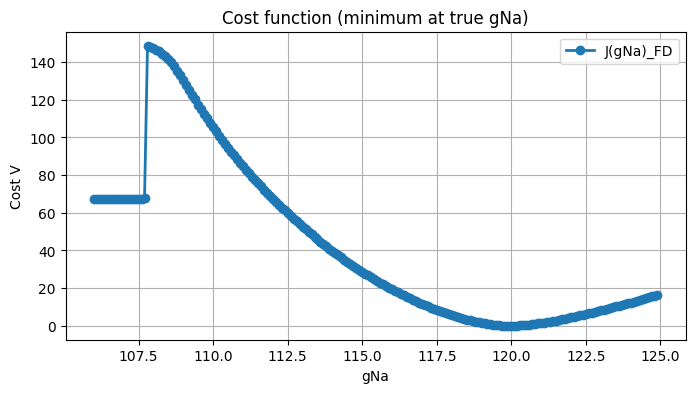

In [ ]:
def compute_cost(sol_model, sol_true, T):
    e = sol_model.y[4] - sol_true.y[4]
    return 0.5 * np.trapz(e**2, sol_model.t) / T



V = np.array([
    compute_cost(solx[i], soly, Tfinal)
    for i in range(len(gNagrid))
])


plt.figure(figsize=(8,4))
plt.plot(gNagrid, V, 'o-', lw=2, label='V(gNa)_FD' )
#plt.ylim(-.1, .2)
#plt.axvline(120, color='r', ls='--', alpha=0.6, label='gNa true')
plt.xlabel('gNa')
plt.ylabel('Cost V')
plt.title('Cost function (minimum at true gNa)')
plt.legend()
plt.grid()
plt.show()


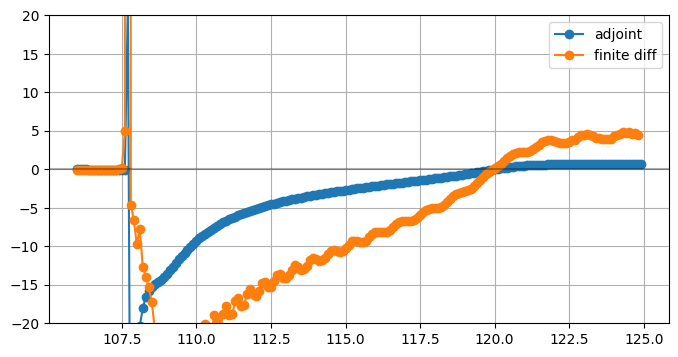

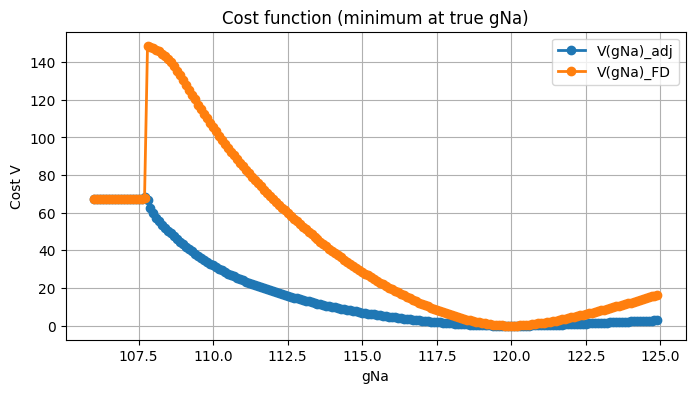

In [15]:

g_mid = gNagrid[:-1]#0.5 * (gNagrid[:-1] + gNagrid[1:])
# careful here the might be a mis alignment

gfd = np.diff(V)/ dg
gad = np.array([
    lambda_traj[gnaidx][9][0]
    for gnaidx in range(len(gNagrid))
])  
# print(gad)
# print(gfd)

plt.figure(figsize=(8,4))
plt.plot(gNagrid, gad, 'o-', label='adjoint')
plt.plot(g_mid, gfd, 'o-', label='finite diff')
plt.ylim(-20, 20)
plt.axhline(0, color='k', alpha=0.3)
plt.legend()
plt.grid()
plt.show()


Vgad = V[0] + np.concatenate([[0], np.cumsum((gad[:-1] + gad[1:])/2) * dg])


plt.figure(figsize=(8,4))
plt.plot( gNagrid,Vgad, 'o-', lw=2, label='V(gNa)_adj' )
plt.plot(gNagrid, V, 'o-', lw=2, label='V(gNa)_FD' )
#plt.ylim(-5, 5)
#plt.axvline(120, color='r', ls='--', alpha=0.6, label='gNa true')
plt.xlabel('gNa')
plt.ylabel('Cost V')
plt.title('Cost function (minimum at true gNa)')
plt.legend()
plt.grid()
plt.show()



In [ ]:
# # write data for pgfplots: columns named "gNagrid", "Vgad", "V"
# import os
# out_path = "/home/jpk/Desktop/Queues/SurrogateGradients/SecondExampleSingleNeuronCostFunctionData.dat"
# data = np.column_stack((gNagrid, Vgad, V))
# header = "gNagrid Vgad V"

# np.savetxt(out_path, data, fmt="%.6e", header=header, comments="")
# print(f"Wrote {data.shape[0]} rows to {out_path}")


# out_path = "/home/jpk/Desktop/Queues/SurrogateGradients/SecondExampleSingleNeuronCostFunctionGradientData.dat"
# data = np.column_stack((gNagrid[:-1], gad[:-1], g_mid, gfd))
# header = "gNagrid gad gnamid gfd"
# np.savetxt(out_path, data, fmt="%.6e", header=header, comments="")
# print(f"Wrote {data.shape[0]} rows to {out_path}")


Wrote 190 rows to /home/jpk/Desktop/Queues/SurrogateGradients/SecondExampleSingleNeuronCostFunctionData.dat
Wrote 189 rows to /home/jpk/Desktop/Queues/SurrogateGradients/SecondExampleSingleNeuronCostFunctionGradientData.dat
